In [86]:
!pip3 install matplotlib

In [87]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

origData = []
FILTER_SIZE = 31

In [88]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 1073741824


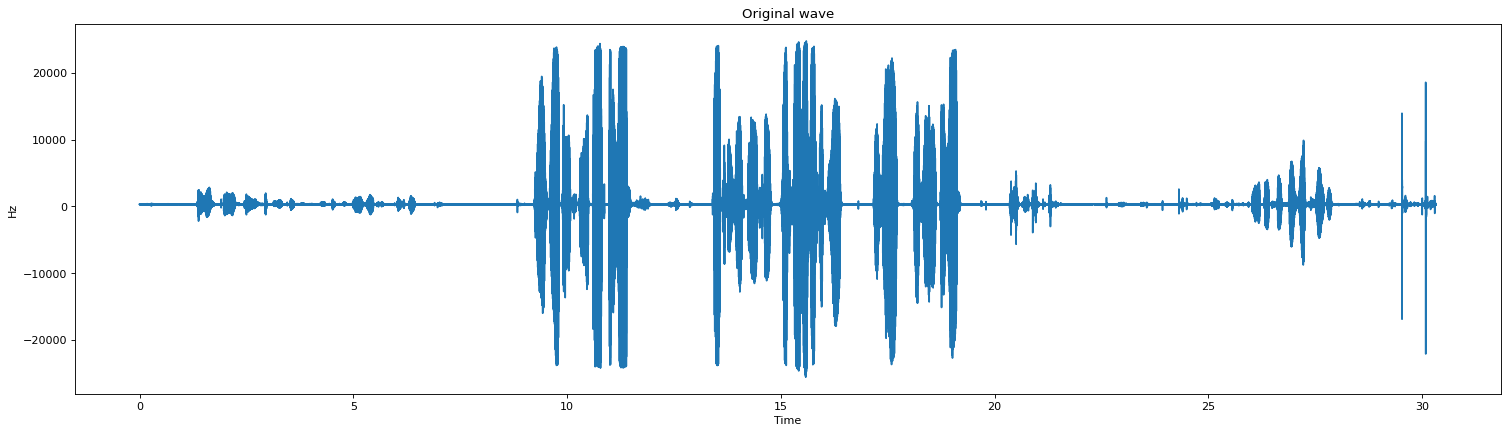

In [89]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize=(23, 6), dpi=80)
plt.xlabel("Time")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [90]:
def update_max(maxVal, val):
    if (val> maxVal):
        maxVal = val

def update_value(newVal: float, oldVal: float, val: float):
    return (val * newVal) + ((1.0 - val) * oldVal)

def frame_size(val1: int, val2: int) -> int:
    frameSize = int(round(float(val1) * (float(val2) / 1000.0)))
    return frameSize + (frameSize % 2)

def limit(minVal, val, maxVal):
    return min(maxVal, max(minVal, val))

In [91]:
class GaussianFilter:
    m_sigma = 0.0
    m_weights = []
    m_filterSize = 0
    
    def __init__(self, filterSize: int):
        self.m_filterSize = filterSize
        self.m_sigma = (((float(self.m_filterSize) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.m_weights = np.zeros(filterSize)
        totalWeight = 0.0
        offset = int(self.m_filterSize / 2)
        c1 = 1.0 / (self.m_sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.m_sigma, 2.0)
    
        for i in range(0, self.m_filterSize):
            x = i - offset
            self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            totalWeight += self.m_weights[i]
    
        adjust = 1.0 / totalWeight
        for i in range(0, self.m_filterSize):
            self.m_weights[i] *= adjust
    
        print(f"filter size = {self.m_filterSize}, sigma = {self.m_sigma}")

    def apply(self, data: list[np.int16]) -> float:
        result = 0.0
        if (data.size() != self.m_filterSize):
            print("Input data wrong size")
            return result

        itr = 0
        for val in data:
            result += val * self.m_weights[itr]
            itr += 1
        
        return result


In [92]:
class AudioNormalizer:
    m_channels = int()
    m_sampleRate = int()
    m_frameLen = int()
    m_filterSize = int()
    m_prefillLen = int()
    m_delay = int()
    m_delayedSamples = int()
    
    m_peakVal = float()
    m_maxAmplification = float()
    m_targetRMS = float()

    m_altBoundaryMode = False

    m_gainHistoryOrig = np.array([], dtype = float)
    m_gainHistoryMin = np.array([], dtype = float)
    m_gainHistorySmooth = np.array([], dtype = float)
    m_prevAmplificationFactor = np.array([], dtype = float)
    m_dcCorrectionValue = np.array([], dtype = float)
    m_compressThreshold = np.array([], dtype = float)

    m_fadeFactors = [np.a] * 2
    m_gauss = None

    def __init__(self, channels: int, sampleRate: int, frameLenMsec: int, filterSize: int,
                 peakValue: float, maxAmplification: float, targetRms: float, compressThresh: float, altBoundaryMode: bool):
        self.m_channels = channels
        self.m_sampleRate = sampleRate
        self.m_frameLen = frame_size(sampleRate, frameLenMsec)
        self.m_filterSize = limit(3, filterSize, 301)
        self.m_prefillLen = int(self.m_filterSize / 2)
        self.m_delay = self.m_frameLen * self.m_filterSize
        self.m_peakValue = limit(0.01, peakValue, 1.0)
        self.m_maxAmplification = limit(1.0, maxAmplification, 100.0)
        self.m_targetRMS = limit(0.0, targetRms, 1.0)
        self.m_altBoundaryMode = altBoundaryMode
        # self.m_fadeFactors[0] = np.array([], dtype = float)
        # self.m_fadeFactors[1] = np.array([], dtype = float)
        
        dStepSize = 1.0 / float(self.m_frameLen)
        for i in range(0, self.m_frameLen):
            self.m_fadeFactors[0].append(1.0 - (dStepSize * float(i + 1)))
            self.m_fadeFactors[1].append(1.0 - self.m_fadeFactors[0][i])

        m_gauss = GaussianFilter(FILTER_SIZE)

        print(f"Params:\n m_channels = {self.m_channels}\n m_sampleRate = {self.m_sampleRate}\n m_frameLen = {self.m_frameLen}\n m_filterSize = {self.m_filterSize}\n m_prefillLen = {self.m_prefillLen}\n m_delay = {self.m_delay}\n m_peakValue = {self.m_peakValue}\n m_maxAmplification = {self.m_maxAmplification}\n m_targetRMS = {self.m_targetRMS}\n m_altBoundaryMode = {self.m_altBoundaryMode}\n m_fadeFactors = {self.m_fadeFactors}")
    
    def analyzeFrame(self, frame):
        pass

    def amplifyFrame(self, frame):
        pass
    
    def getMaxLocalGain(self, frame, channel: int) -> float:
        pass

    def findPeakMagnitude(self, frame, channel: int) -> float:
        pass

    def computeFrameRMS(self, frame, channel: int) -> float:
        pass

    def updateGainHistory(channel: int, currGainFactor: float):
        pass
    
    def performDCCorrection(self, data: list[np.int16], isFirstFrame: bool):
        diff = 1.0 / float(self.m_frameLen)
        currAvgVal = 0.0
        for i in range(0, self.m_frameLen):
            currAvgVal += (data[i] * diff)

        prevVal = currAvgVal if isFirstFrame else self.m_dcCorrectionValue
        self.m_dcCorrectionValue = currAvgVal if isFirstFrame else self.updateValue(currAvgVal, self.m_dcCorrectionValue, 0.1)

        for i in range(0, self.m_fameLen):
            data[i] -= self.fade(prevVal, self.m_dcCorrectionValue, i)

    def findPeakMagnitude(self, data: list[np.int16], channel):
        dMax = sys.float_info.epsilon
        if (None == channel):
            for i in range(0, self.m_frameLen):
                self.update_max(dMax, math.fabs(data[i]))
        else:
            for i in range(0, self.m_frameLen):
                pass

    def setupCompressThresh(self, threshold: float) -> float:
        pass

In [93]:
audioNorm = AudioNormalizer(origCh, origRate, 160, FILTER_SIZE, 1, 100, 0.0, 0.0, False)

AttributeError: 'NoneType' object has no attribute 'append'

In [ ]:
plt.figure(figsize=(23, 6), dpi=80)
plt.xlabel("Time")
plt.ylabel("Hz")
plt.title("Gauss processed")
plt.plot(time, origPlotData)
plt.show()